# RL CartPole: Actor-Critic SAC  with Pytorch

In [1]:
import numpy as np
import gym
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque, namedtuple
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
cpu_count = os.cpu_count()
print(f"CPU count: {cpu_count}")
torch.set_num_threads(cpu_count)
print(f"PyTorch threads: {torch.get_num_threads()}")
print(f"PyTorch device: {device}")



CPU count: 12
PyTorch threads: 12
PyTorch device: cpu


In [21]:

# Environmental global variables:
SEED = 42

# Making the environment:
#env = gym.make('LunarLander-v2')
env = gym.make('CartPole-v1')
env.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
env.action_space.seed(SEED)  # Ensures deterministic action sampling

# Hyperparameters:
learning_rate = 0.0001
gamma = 0.99
num_episodes = 1500
TAU = 0.01
replay_memory_capacity = int(1e5)
batch_size = 100
MEMORY_SIZE = int(1e5)
frequency_update = 2



# Defining the neural network:
space_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(f"Space_dim: {space_dim}, Action_dim: {action_dim}")


class Actor_Model(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor_Model, self).__init__()
        self.seed = torch.manual_seed(SEED)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, state):
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        action_probabilities = F.softmax(self.fc3(state), dim=1)
        return action_probabilities
    
    
class Critic_Model(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic_Model, self).__init__()
        self.seed = torch.manual_seed(SEED)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)    
        self.fc3 = nn.Linear(64, action_size)             # Output is a single value (V(s) value)

    def forward(self, state):
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        state_value = self.fc3(state)
        return state_value
    
    
    
# Defining the ReplayBuffer
class ReplayBuffer:
    def __init__(self, buffer_size, action_size):
        self.seed = random.seed(SEED)
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.experiences = namedtuple("Experiences", field_names=["state","action","reward","new_state", "done"])
        
    def add(self, state, action, reward, new_state, done):
        e = self.experiences(state, action, reward, new_state, done)
        self.memory.append(e)
        
    def sample(self, batch_size):
        experiences = random.sample(self.memory, k=batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        new_states = torch.from_numpy(np.vstack([e.new_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return states, actions, rewards, new_states, dones
    
    def __len__(self):
        return len(self.memory)



class SACAgent:
    def __init__(self, state_size, action_size):
        self.t_step = 0
        self.tau = TAU
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_episodes = num_episodes

        self.seed = random.seed(SEED)
        self.state_size = state_size
        self.action_size = action_size
        self.update_frequency = frequency_update

        self.memory = ReplayBuffer(buffer_size=MEMORY_SIZE,action_size=action_size)

        # Actor Network
        self.actor_nn = Actor_Model(state_size=state_size, action_size=action_size).to(device)
        self.optimizer_actor = optim.Adam(self.actor_nn.parameters(), lr=self.learning_rate)

        # Critic Networks
        self.critic1_online_nn = Critic_Model(state_size=state_size, action_size=action_size).to(device)
        self.critic1_target_nn = Critic_Model(state_size=state_size, action_size=action_size).to(device)
        self.optimizer_critic1_local = optim.Adam(self.critic1_online_nn.parameters(), lr=self.learning_rate)

        # Entropy Parameters
        self.alpha_entropy = 0.0
        

    def choose_action(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        action_probs = self.actor_nn(state_tensor)
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample().item()
        return action
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state=state,action=action, reward=reward,new_state=next_state,done=done)

        self.t_step = (self.t_step + 1) % self.update_frequency
        update_flag = self.t_step == 0
        if update_flag:
            if self.memory.__len__() > self.batch_size:
                experiences = self.memory.sample(batch_size=self.batch_size)
                self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Update the critic networks
        self.update_critic(states, actions, rewards, next_states, dones)

        # Update the actor network
        self.update_actor(states, actions)

        # Update the target networks
        self.soft_update(critic_model_online=self.critic1_online_nn, critic_model_target=self.critic1_target_nn)


    def update_critic(self, states, actions, rewards, next_states, dones):
        #print(f"\n ======================================== Update Critic ======================================== \n")
        with torch.no_grad():
            next_action_probs = self.actor_nn(next_states)
            next_log_probs = torch.log(next_action_probs + 1e-7)

            q_next = self.critic1_target_nn(next_states)
            q_next_expected = (next_action_probs * (q_next - self.alpha_entropy * next_log_probs)).sum(dim=1, keepdim=True)

            y_target = rewards + self.gamma * (1 - dones) * q_next_expected
            #print(f"Shape of y_target: {y_target.shape}")

        # Step 2: Compute the Q values for the current state
        q_values_current = self.critic1_online_nn(states).gather(1, actions)
        #print(f"Shape of q_values_current: {q_values_current.shape}")
      


        # Compute critic loss
        critic_loss = F.mse_loss(q_values_current, y_target)

        # Update the critic
        self.optimizer_critic1_local.zero_grad()
        critic_loss.backward()
        self.optimizer_critic1_local.step()
        


    def update_actor(self, states, actions):
        #print(f"\n ======================================== Update Actor ======================================== \n")

        probs = self.actor_nn(states)
        log_probs = torch.log(probs + 1e-7)  
        entropy_part = self.alpha_entropy * log_probs
        entropy_part_final = entropy_part.sum(dim=1, keepdim=True)

        q_values = self.critic1_online_nn(states)
        weighted_q = (probs * q_values).sum(dim=1, keepdim=True)  # Expectation under policy

        actor_loss = (self.alpha_entropy * log_probs - weighted_q).mean()

        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()



    
    def soft_update(self, critic_model_online, critic_model_target):
        """
        Apply soft update to the target critic model using the online critic model.
        
        Args:
            self: The current instance of the class (which has critic networks).
            critic_model_online: The online critic model (current model).
            critic_model_target: The target critic model (the one to be updated).
        """
        with torch.no_grad():
            # Apply soft update to the target critic network
            for target_param, online_param in zip(critic_model_target.parameters(), critic_model_online.parameters()):
                target_param.data.copy_((1 - self.tau) * target_param.data + self.tau * online_param.data)





def plot_training(mean_rewards_list, total_rewards_list):
    # Use Seaborn to plot rewards per episode
    sns.set_style("darkgrid")  # Set a nice style
    plt.figure(figsize=(10, 5))  # Set figure size

    sns.lineplot(x=range(len(total_rewards_list)), y=total_rewards_list, label="Total Reward per Episode")
    sns.lineplot(x=range(len(mean_rewards_list)), y=mean_rewards_list, label="Mean Reward (50 episodes)")

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress: Rewards per Episode")
    plt.legend()
    plt.show()

def print_training_parameters(learning_rate, gamma, num_episodes, TAU, SEED):
    print(f"\n")
    print(f"=====================================================================================================")
    print(f"==================================== Training Parameters ===========================================")
    print(f"=====================================================================================================")
    print(f"Number of Episodes: {num_episodes	}")
    print(f"TAU: {TAU}")
    print(f"Learning rate: {learning_rate}")
    print(f"Gamma: {gamma}")
    print(f"Seed: {SEED}")
    print(f"=====================================================================================================")
    print(f"\n")




# Making the RL_model
def train_Agent():
  

    
    print_training_parameters(learning_rate=learning_rate, num_episodes=num_episodes,gamma=gamma, TAU=TAU, SEED=SEED)
    mean_rewards_list = []
    total_rewards_list = []
    best_mean_reward = -np.inf
    total_rewards = 0

    
    #Make the agent
    agent = SACAgent(state_size=space_dim, action_size=action_dim)


    mean_rewards_list = []
    total_rewards_list = []
    best_actions_list = []
    best_states_list = []
    best_episode_rewards_list = []
    best_soc_list = []
    best_mean_reward = -np.inf
    global done_flag
    done_flag = False

    for i_episode in range(num_episodes):
        state = env.reset()
        actions_list = []
        states_list = []
        episode_rewards_list = []
        soc_list = []
        reward_list = []


        done = False
        episode_rewards = 0
        iter = 0
        #print(f"\n  ---- Episode {i_episode} ----:")

        while not done:
            states_list.append(state)
            #print(f"State: {state}")
            action = agent.choose_action(state=state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)

            state = next_state

            episode_rewards += reward
            iter +=1
      
            episode_rewards_list.append(episode_rewards)
   
            
    
            if done:
                #print(f"Starting information Episode {iter}: Starting balance: {self.env.balance}, Starting Stocks: {self.env.stocks_owned} Total_rewards: {episode_rewards} \n")
                break


        total_rewards_list.append(episode_rewards)
        mean_rewards = np.mean(total_rewards_list[-50:] if len(total_rewards_list) >= 50 else 1)
        mean_rewards_list.append(mean_rewards)

        if i_episode % 200 == 0:
            print(f" Episode: {i_episode}, Total Reward: {episode_rewards}, Mean Reward: {mean_rewards}")
 

        if episode_rewards > best_mean_reward:
            #print(f"Updating at Episode: {i_episode}, Total Reward: {mean_rewards}")
            best_mean_reward = episode_rewards

            
    

    plot_training(mean_rewards_list, total_rewards_list)


Space_dim: 4, Action_dim: 2




==================================== Training Parameters ===========================================
Number of Episodes: 1500
TAU: 0.01
Learning rate: 0.0001
Gamma: 0.99
Seed: 42


 Episode: 0, Total Reward: 26.0, Mean Reward: 1.0
 Episode: 200, Total Reward: 8.0, Mean Reward: 9.74
 Episode: 400, Total Reward: 15.0, Mean Reward: 28.64
 Episode: 600, Total Reward: 225.0, Mean Reward: 337.62
 Episode: 800, Total Reward: 165.0, Mean Reward: 209.62
 Episode: 1000, Total Reward: 500.0, Mean Reward: 330.06
 Episode: 1200, Total Reward: 243.0, Mean Reward: 405.42
 Episode: 1400, Total Reward: 500.0, Mean Reward: 492.04


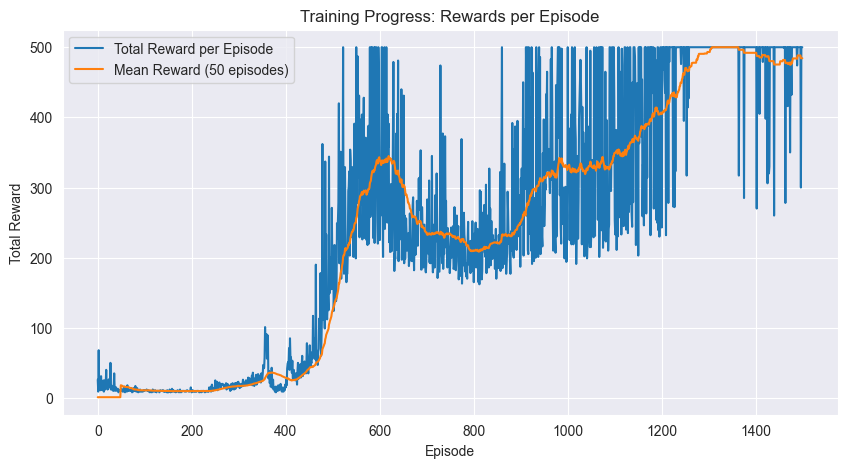

In [22]:
train_Agent()

In [6]:
import numpy as np
import torch



import torch


class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        self.layer_1 = torch.nn.Linear(in_features=input_dimension, out_features=64)
        self.layer_2 = torch.nn.Linear(in_features=64, out_features=64)
        self.output_layer = torch.nn.Linear(in_features=64, out_features=output_dimension)
        self.output_activation = output_activation

    def forward(self, inpt):
        layer_1_output = torch.nn.functional.relu(self.layer_1(inpt))
        layer_2_output = torch.nn.functional.relu(self.layer_2(layer_1_output))
        output = self.output_activation(self.output_layer(layer_2_output))
        return output
    
import numpy as np


class ReplayBuffer:

    def __init__(self, environment, capacity=5000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 10**-2
        self.delta = 10**-4
        self.indices = None

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        # type str for transition = 'state type, action type, reward type, state type'
        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count


class SACAgent:

    ALPHA_INITIAL = 1.
    REPLAY_BUFFER_BATCH_SIZE = 100
    DISCOUNT_RATE = 0.99
    LEARNING_RATE = 10 ** -4
    SOFT_UPDATE_INTERPOLATION_FACTOR = 0.001

    def __init__(self, environment):
        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n
        self.critic_local = Network(input_dimension=self.state_dim,
                                    output_dimension=self.action_dim)
        self.critic_local2 = Network(input_dimension=self.state_dim,
                                     output_dimension=self.action_dim)
        self.critic_optimiser = torch.optim.Adam(self.critic_local.parameters(), lr=self.LEARNING_RATE)
        self.critic_optimiser2 = torch.optim.Adam(self.critic_local2.parameters(), lr=self.LEARNING_RATE)

        self.critic_target = Network(input_dimension=self.state_dim,
                                     output_dimension=self.action_dim)
        self.critic_target2 = Network(input_dimension=self.state_dim,
                                      output_dimension=self.action_dim)

        self.soft_update_target_networks(tau=1.)

        self.actor_local = Network(
            input_dimension=self.state_dim,
            output_dimension=self.action_dim,
            output_activation=torch.nn.Softmax(dim=1)
        )
        self.actor_optimiser = torch.optim.Adam(self.actor_local.parameters(), lr=self.LEARNING_RATE)

        self.replay_buffer = ReplayBuffer(self.environment)

        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.ALPHA_INITIAL), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.LEARNING_RATE)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action


    def train_on_transition(self, state, discrete_action, next_state, reward, done):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition)

    def train_networks(self, transition):
        # Set all the gradients stored in the optimisers to zero.
        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()
        self.actor_optimiser.zero_grad()
        self.alpha_optimiser.zero_grad()
        # Calculate the loss for this transition.
        self.replay_buffer.add_transition(transition)
        # Compute the gradients based on this loss, i.e. the gradients of the loss with respect to the Q-network
        # parameters.
        if self.replay_buffer.get_size() >= self.REPLAY_BUFFER_BATCH_SIZE:
            # get minibatch of 100 transitions from replay buffer
            minibatch = self.replay_buffer.sample_minibatch(self.REPLAY_BUFFER_BATCH_SIZE)
            minibatch_separated = list(map(list, zip(*minibatch)))

            # unravel transitions to get states, actions, rewards and next states
            states_tensor = torch.tensor(np.array(minibatch_separated[0]))
            actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
            done_tensor = torch.tensor(np.array(minibatch_separated[4]))

            critic_loss, critic2_loss = \
                self.critic_loss(states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor)

            critic_loss.backward()
            critic2_loss.backward()
            self.critic_optimiser.step()
            self.critic_optimiser2.step()

            actor_loss, log_action_probabilities = self.actor_loss(states_tensor)

            actor_loss.backward()
            self.actor_optimiser.step()

            alpha_loss = self.temperature_loss(log_action_probabilities)

            alpha_loss.backward()
            self.alpha_optimiser.step()
            self.alpha = self.log_alpha.exp()

            self.soft_update_target_networks()

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor):
        actions_tensor = actions_tensor.long()  # Ensure actions_tensor is an integer type
        with torch.no_grad():
            action_probabilities, log_action_probabilities = self.get_action_info(next_states_tensor)
            next_q_values_target = self.critic_target.forward(next_states_tensor)
            next_q_values_target2 = self.critic_target2.forward(next_states_tensor)
            soft_state_values = (action_probabilities * (
                    torch.min(next_q_values_target, next_q_values_target2) - self.alpha * log_action_probabilities
            )).sum(dim=1)

            next_q_values = rewards_tensor + ~done_tensor * self.DISCOUNT_RATE*soft_state_values
        #print(f"next_q_values: {next_q_values.shape}")
        soft_q_values = self.critic_local(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
        soft_q_values2 = self.critic_local2(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
        critic_square_error = torch.nn.MSELoss(reduction="none")(soft_q_values, next_q_values)
        critic2_square_error = torch.nn.MSELoss(reduction="none")(soft_q_values2, next_q_values)
        weight_update = [min(l1.item(), l2.item()) for l1, l2 in zip(critic_square_error, critic2_square_error)]
        self.replay_buffer.update_weights(weight_update)
        critic_loss = critic_square_error.mean()
        critic2_loss = critic2_square_error.mean()
        return critic_loss, critic2_loss

    def actor_loss(self, states_tensor,):
        action_probabilities, log_action_probabilities = self.get_action_info(states_tensor)
        q_values_local = self.critic_local(states_tensor)
        q_values_local2 = self.critic_local2(states_tensor)
        inside_term = self.alpha * log_action_probabilities - torch.min(q_values_local, q_values_local2)
        policy_loss = (action_probabilities * inside_term).sum(dim=1).mean()
        return policy_loss, log_action_probabilities

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.squeeze(0).detach().numpy()

    def soft_update_target_networks(self, tau=SOFT_UPDATE_INTERPOLATION_FACTOR):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)
    

import gym
import numpy as np
import matplotlib.pyplot as plt



TRAINING_EVALUATION_RATIO = 4
RUNS = 5
EPISODES_PER_RUN = 400
STEPS_PER_EPISODE = 500

env = gym.make("CartPole-v1")
agent_results = []
for run in range(RUNS):
    agent = SACAgent(env)
    run_results = []
    for episode_number in range(EPISODES_PER_RUN):
        print('\r', f'Run: {run + 1}/{RUNS} | Episode: {episode_number + 1}/{EPISODES_PER_RUN}', end=' ')
        evaluation_episode = episode_number % TRAINING_EVALUATION_RATIO == 0
        episode_reward = 0
        state = env.reset()
        done = False
        i = 0
        while not done and i < STEPS_PER_EPISODE:
            i += 1
            action = agent.get_next_action(state, evaluation_episode=evaluation_episode)
            next_state, reward, done, info = env.step(action)
            if not evaluation_episode:
                agent.train_on_transition(state, action, next_state, reward, done)
            episode_reward += reward
            state = next_state
        if evaluation_episode:
            run_results.append(episode_reward)
        print(f"Episode: {episode_number}, Reward: {episode_reward}")
    agent_results.append(run_results)

env.close()

n_results = EPISODES_PER_RUN // TRAINING_EVALUATION_RATIO
results_mean = [np.mean([agent_result[n] for agent_result in agent_results]) for n in range(n_results)]
results_std = [np.std([agent_result[n] for agent_result in agent_results]) for n in range(n_results)]
mean_plus_std = [m + s for m, s in zip(results_mean, results_std)]
mean_minus_std = [m - s for m, s in zip(results_mean, results_std)]

x_vals = list(range(len(results_mean)))
x_vals = [x_val * (TRAINING_EVALUATION_RATIO - 1) for x_val in x_vals]

ax = plt.gca()
ax.set_ylim([0, 200])
ax.set_ylabel('Episode Score')
ax.set_xlabel('Training Episode')
ax.plot(x_vals, results_mean, label='Average Result', color='blue')
ax.plot(x_vals, mean_plus_std, color='blue', alpha=0.1)
ax.plot(x_vals, mean_minus_std, color='blue', alpha=0.1)
ax.fill_between(x_vals, y1=mean_minus_std, y2=mean_plus_std, alpha=0.1, color='blue')
plt.legend(loc='best')
plt.show()

 Run: 1/5 | Episode: 1/400 Episode: 0, Reward: 9.0
 Run: 1/5 | Episode: 2/400 Episode: 1, Reward: 20.0
 Run: 1/5 | Episode: 3/400 Episode: 2, Reward: 18.0
 Run: 1/5 | Episode: 4/400 Episode: 3, Reward: 29.0
 Run: 1/5 | Episode: 5/400 Episode: 4, Reward: 10.0
 Run: 1/5 | Episode: 6/400 Episode: 5, Reward: 29.0
 Run: 1/5 | Episode: 7/400 Episode: 6, Reward: 20.0
 Run: 1/5 | Episode: 8/400 Episode: 7, Reward: 36.0
 Run: 1/5 | Episode: 9/400 Episode: 8, Reward: 9.0
 Run: 1/5 | Episode: 10/400 Episode: 9, Reward: 40.0
 Run: 1/5 | Episode: 11/400 Episode: 10, Reward: 20.0
 Run: 1/5 | Episode: 12/400 Episode: 11, Reward: 10.0
 Run: 1/5 | Episode: 13/400 Episode: 12, Reward: 31.0
 Run: 1/5 | Episode: 14/400 Episode: 13, Reward: 19.0
 Run: 1/5 | Episode: 15/400 Episode: 14, Reward: 8.0
 Run: 1/5 | Episode: 16/400 Episode: 15, Reward: 12.0
 Run: 1/5 | Episode: 17/400 Episode: 16, Reward: 10.0
 Run: 1/5 | Episode: 18/400 Episode: 17, Reward: 9.0
 Run: 1/5 | Episode: 19/400 Episode: 18, Reward: 17

KeyboardInterrupt: 